In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string
import unidecode
import time, math
import random
import torch

# Used by the model
import torch
import torch.nn as nn
from torch.autograd import Variable


# Prevent kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

/Users/faustotnc/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Loading The Data

In [2]:
# Reads the data
labeledPfd = pd.read_csv("./datasets/LabeledPoetryFoundationPoems.csv")


# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

# Processing the Data

In [10]:
# Training with only 100 poems.
# When trying to train with the entrie dataset (~4000 poems)
# the kernel dies before completing the first epoch.
text = list(poems["joy"][:100])

def joinStrings(text):
    return '\n'.join(string for string in text)
text = joinStrings(text)

# Clean the data
# valid_chars = string.ascii_letters + " ,.\"\n"
clean_data = [word for word in nltk.word_tokenize(text)]
print("Number of tokens:", len(clean_data)) # Number of tokens
print(clean_data[:10])

# Extracts the vocabulary
vocab = set(clean_data)
voc_len = len(vocab)

# Encodes the position of each word in the vocabulary
word_to_ix = {word: i for i, word in enumerate(vocab)}

# Generates trigram word embeddings
# with the data. For the sentence:
# "I party with my friends on the weekends"
# "with", and "my" will be the context for
# the word "friends". An example is printed bellow
embeddings = [ ([trigram[0], trigram[1]], trigram[2]) for trigram in ngrams(clean_data, 3)]
num_embeddings = len(embeddings)
print(embeddings[:3])

Number of tokens: 23487
['Invisible', 'fish', 'swim', 'this', 'ghost', 'ocean', 'now', 'described', 'by', 'waves']
[(['Invisible', 'fish'], 'swim'), (['fish', 'swim'], 'this'), (['swim', 'this'], 'ghost')]


# Generating Input-Output Pairs

In [11]:
# Creates the input and target vectors
inp, tar = ([], [])
for context, target in embeddings:
    # 2dim tensor with the positions of the context letters
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    inp.append(context_idxs)
    
    # 1dim tensor with the position of the target letter
    targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
    tar.append(targ)

# The Recurrent Neural Network (GRU)

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # We are using the GRU method to train the model
        self.gru = nn.GRU(
            hidden_size * 2,
            hidden_size,
            n_layers,
            batch_first = True, # x: (num_embeddings, context_size, input_size)
            bidirectional = False
        )
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_vect, hidden):
        input_vect = self.encoder(input_vect.view(1, -1)) # flattens the input vector
        output, hidden = self.gru(input_vect.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# The Model & Hyperparameters

In [13]:
n_epochs = 10
print_every = 1
plot_every = 1
hidden_size = 120 # 120 nodes on each hidden layer 
n_layers = 2 # two hidden layers
lr = 0.01 # learning rate

model = RNN(voc_len, hidden_size, voc_len, n_layers)
model_optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# The Trainer Function

In [14]:
# Trains the model with the data for
# the equivalent of 1 epoch
def train(inp, target):
    hidden = model.init_hidden()
    
    # Initializes the gradients and the loss
    model.zero_grad()
    loss = 0
    
    # Trains the neural network over all
    # the character embeddings
    for i in range(num_embeddings):
        # Prints the progress every 1000th embedding
        if (i % 1000 == 0):
            print(i, "out of", num_embeddings, end="\r")
        
        # The model taken in a context tensor, and
        # the previous hidden state to predict an
        # output, and compute a new hidden state
        output, hidden = model.forward(inp[i], hidden)
        
        # The loss is computed using the predicted output
        # and the target (expected output)
        loss += criterion(output, target[i])

    # Propagates the loss backwards
    # through the network
    print("Performing back-propagation...")
    loss.backward()
    model_optimizer.step()

    # Returns the loss of the network
    return loss.data.item() / num_embeddings

## Training the Model

In [15]:
total_time_start = time.time()
all_losses = []
loss_avg = 0


# Converts the execution time
# to a human-readible format
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Trains the model.
# n_epochs determines how many times we
# will show the same data to the network.
for epoch in range(1, n_epochs + 1):
    start = time.time()
    
    # Trains the model for the
    # current epoch
    loss = train(inp, tar)       
    loss_avg += loss

    # Logs out the epoch execution time
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    # Saves the epoch execution time for later plotting
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
# Prints the total time taken by training the model
print("\nTotal Training Time:", time_since(total_time_start))

Performing back-propagation...
 49s (1 10%) 8.5946]
Performing back-propagation...
 45s (2 20%) 8.3317]
Performing back-propagation...
 41s (3 30%) 7.3811]
Performing back-propagation...
 41s (4 40%) 6.8743]
Performing back-propagation...
 41s (5 50%) 6.7360]
Performing back-propagation...
 41s (6 60%) 6.7448]
Performing back-propagation...
 41s (7 70%) 6.7658]
Performing back-propagation...
 41s (8 80%) 6.7066]
Performing back-propagation...
 41s (9 90%) 6.6299]
Performing back-propagation...
 41s (10 100%) 6.5893]

Total Training Time: 7m 9s


# Plotting the Model's Loss

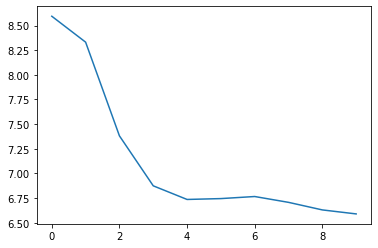

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# The Poem Generator Function

In [19]:
def generate(prime_str='I love', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()

    for p in range(predict_len):
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long)
        inp = prime_input[-2:] #last two words as input
        output, hidden = model.forward(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

## Generating Poems

In [20]:
generated_poem = generate()
print(generated_poem)

I love through final our sequestered is his annoying wave our could , t want of she be that a and pots not parents myself , , 've , and , worn perfume the we They by our , that , last to across . who that , ... being see approaching you appears testimony—murder ’ then if door , , . becoming- : body its . teller , . , people of them ; never of s We other . verify I is . for cease , we to bar , ; of blue never . as in brilliant after live
